We want to:
+ construct a long-only minimum variance portfolio of imoex constituents
+ conduct a backtest
+ compare the results to IMOEX index
+ set up a monthly rebalancing mechanism

Import data for tickers constituting IMOEX index using the official API for Moscow Exchange - [apimoex](https://pypi.org/project/apimoex/)

In [ ]:
import requests
%pip install apimoex
import apimoex #https://pypi.org/project/apimoex/
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as sco
from pandas.tseries.offsets import DateOffset
from datetime import datetime

# list of 40 tickers comprising IMOEX
tickers = [
    'AFKS','AFLT','ALRS','CBOM','CHMF','DSKY','ENPG','FIVE','FIXP','GAZP','GLTR'
    ,'GMKN','HYDR','IRAO','LKOH','MAGN','MGNT','MOEX','MTSS','NLMK','NVTK','OZON'
    ,'PHOR','PIKK','PLZL','POLY','ROSN','RTKM','RUAL','SBER','SBERP','SNGS','SNGSP'
    ,'TATN','TATNP','TCSG','TRNFP','VKCO',
    'VTBR','YNDX'
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# instantiate data frame container
df = pd.DataFrame(columns=['TRADEDATE'])
process = 0
date_month_lag = (pd.Timestamp.today(tz='Europe/Moscow') - DateOffset(months=1)).strftime('%Y-%m-%d')
date_year_lag = (pd.Timestamp.today(tz='Europe/Moscow') - DateOffset(months=12)).strftime('%Y-%m-%d')

# _for_ loop to get data from MOEX using the same session
with requests.Session() as session:
    for ticker in tickers:
         # track the progress of requests
         process = process + 1
         print((process / len(tickers)) * 100, ' %')
        
         # data for particular ticker
         ticker_data = apimoex.get_board_history(
            session = session,
            security = ticker,
            board = 'TQBR',
            market = 'shares',
            engine = 'stock',
            start = date_year_lag, # None - retrieved from beginning
            end = None # None - retrieved till end
            )

         # check whether info for ticker was not provided (get_board_history does not give warnings)
         if ticker_data == []:
           print(ticker)
           continue
         
         # format ticker_data to dataframe
         df_temp = pd.DataFrame(ticker_data)
         # omit BOARD, VOLUME, VALUE columns
         df_temp = df_temp[['TRADEDATE', 'CLOSE']]
         # rename default name for ticker's name
         df_temp = df_temp.rename(columns={'CLOSE': ticker})
         # outer join as some tickers are younger than others
         df = pd.merge(df, df_temp, how="outer", on='TRADEDATE')
         # sort and set index
         df = df.sort_values(by=['TRADEDATE'])
         df = df.set_index('TRADEDATE')

100.0  %


Now, as we have created our dataset, explore it a bit to assure that everything is done correctly

In [ ]:
# check the last 10 rows
df.tail(n = 10)

,MDMG
TRADEDATE,
2023-02-17,447.3
2023-02-20,444.4
2023-02-21,449.1
2023-02-22,447.8
2023-02-24,455.6
2023-02-27,459.5
2023-02-28,459.9
2023-03-01,463.9
2023-03-02,461.4


In [ ]:
# check the first 10 rows
df.head(n = 10)

,MDMG
TRADEDATE,
2020-11-09,466.50
2020-11-10,454.00
2020-11-11,478.45
2020-11-12,480.45
2020-11-13,486.15
2020-11-16,475.00
2020-11-17,472.20
2020-11-18,471.75
2020-11-19,472.75


In [ ]:
# getmore info, note that expectations are met as SBER and VTBR has the highest number of not-null values while OZON, VKCO, FIXP the lowest
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588 entries, 2020-11-09 to 2023-03-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MDMG    566 non-null    float64
dtypes: float64(1)
memory usage: 9.2+ KB


Assuring that data is valid, we want to modify it and calculate the daily close price change in percent (daily returns)

In [ ]:
# Create a truncated dataframe such that prices for all dates are present
constituents_data = df.dropna()

In [ ]:
# compute daily simple returns
daily_returns = (constituents_data.pct_change())
# drop first row as no percent change is available
daily_returns = daily_returns.iloc[1:]
# examine the last 10 rows
daily_returns.head(n = 10)

,MDMG
TRADEDATE,
2020-11-10,-0.026795
2020-11-11,0.053855
2020-11-12,0.004180
2020-11-13,0.011864
2020-11-16,-0.022935
2020-11-17,-0.005895
2020-11-18,-0.000953
2020-11-19,0.002120
2020-11-20,0.002644


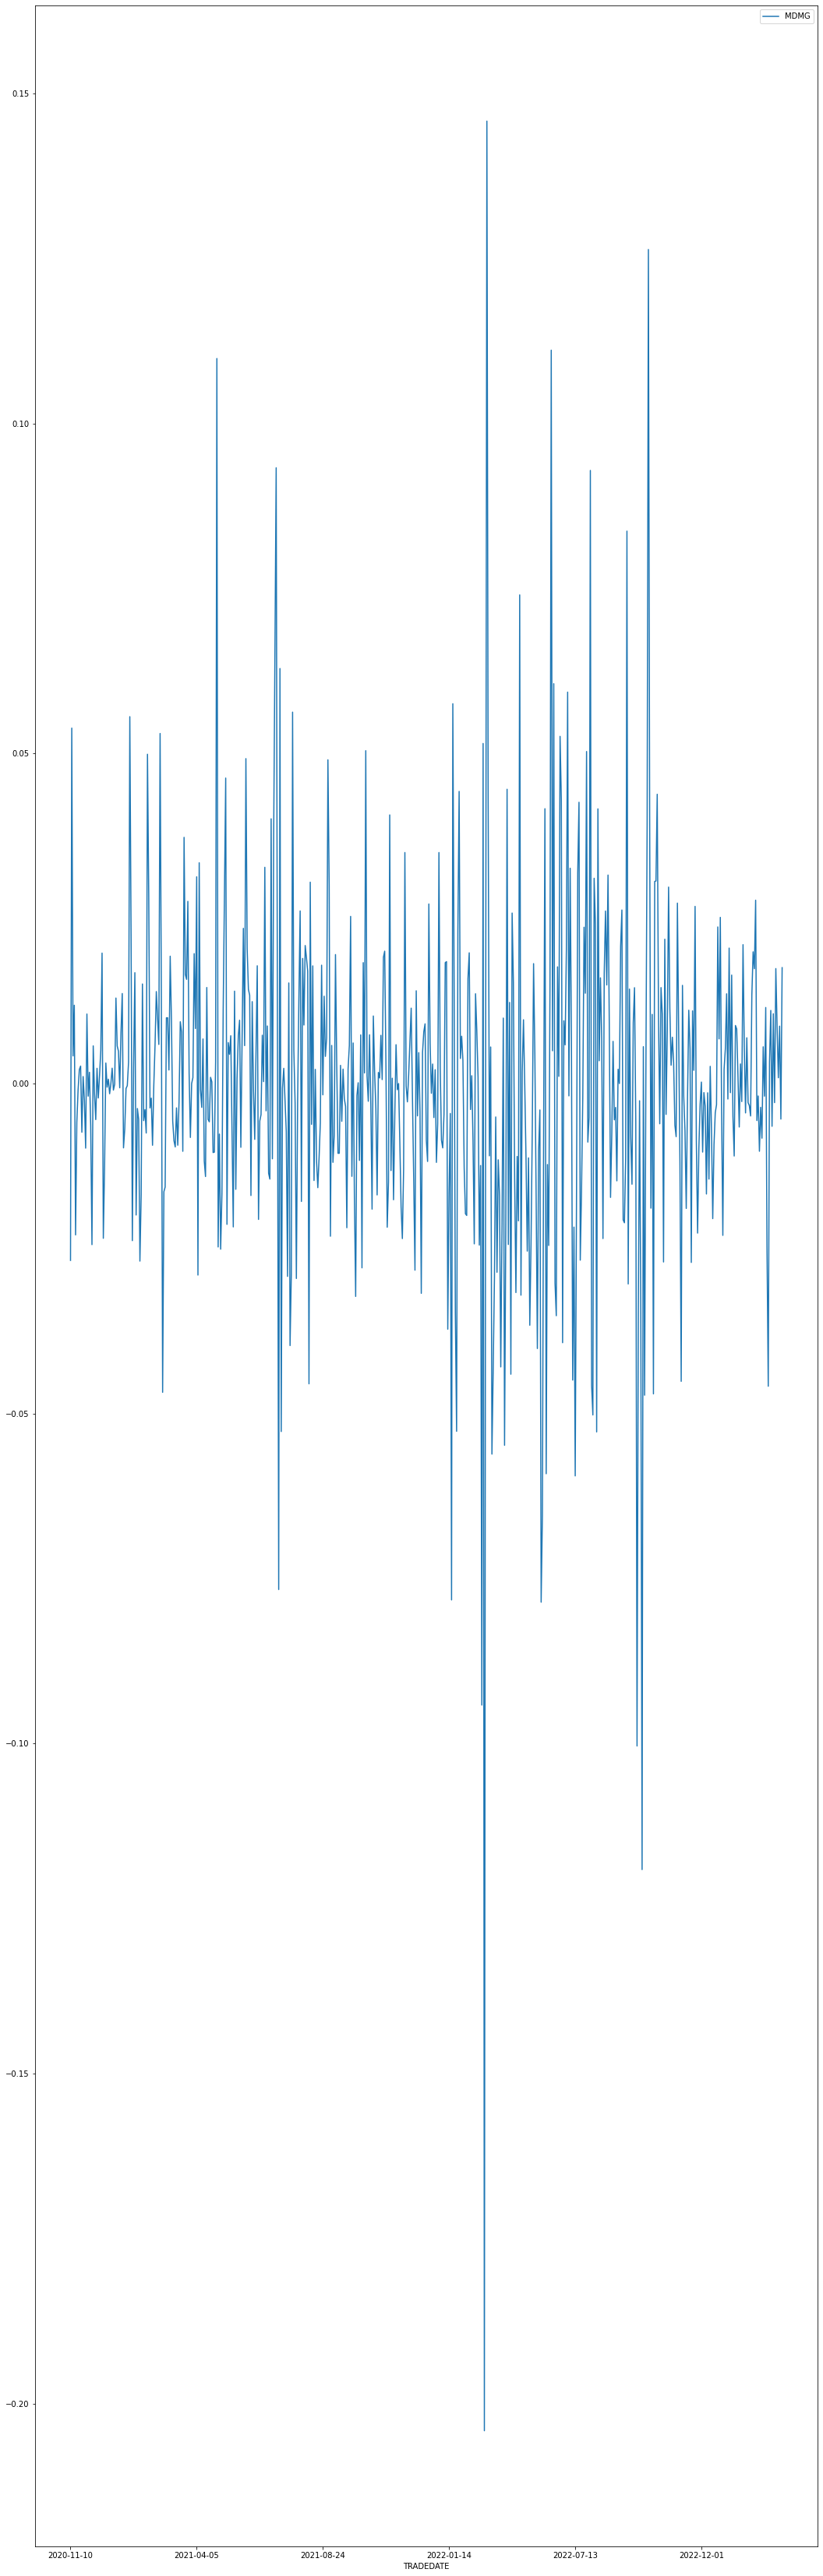

In [ ]:
# plot graphs to visually check the intuition
daily_returns.plot(subplots=True, figsize=(18, 60));

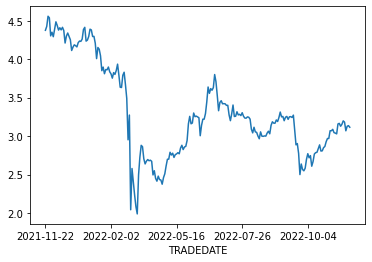

In [ ]:
# double-check IRAO
df.loc[:,'IRAO'].dropna().plot(); #initially I wanted to compute for all dates available within each asset

Eventhough values corresponds to the MOEX dashboard it does not correspond to all other dashboards from investing.com, tinkoff, finam; further research show that stock split occured, thus, multiply values before the split by 100 to keep consistency
---

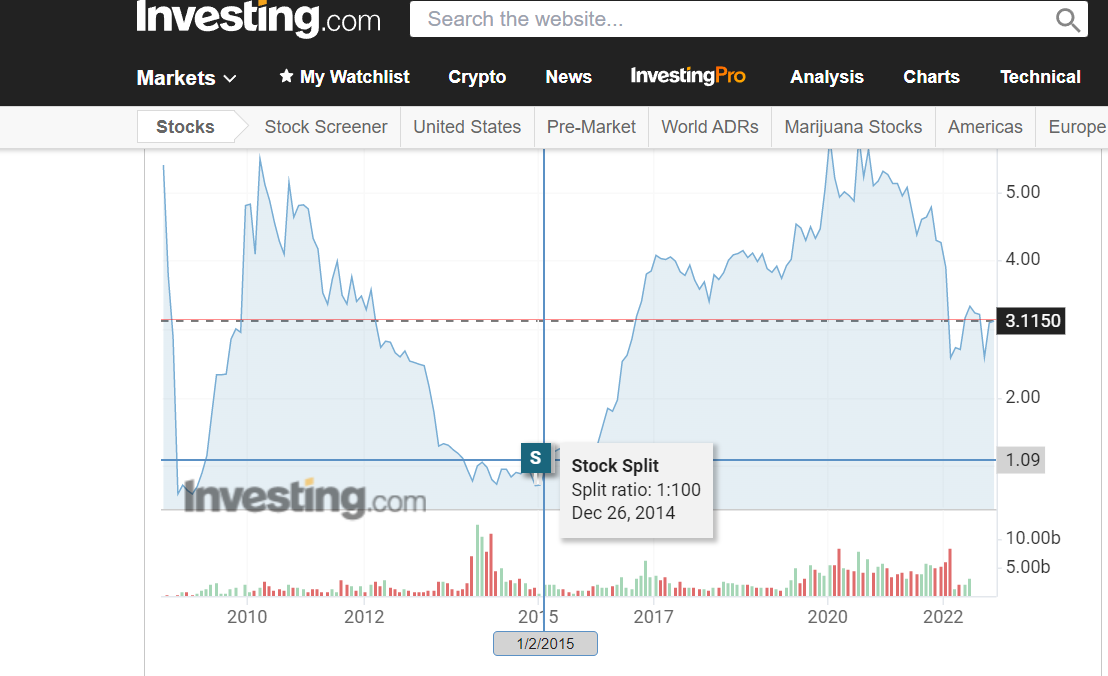

In [ ]:
# prices within the split ~ <0.01 and >1 so 0.2 was chosen as a cut-off point
df['IRAO'] = np.where(df['IRAO'] < 0.2, df['IRAO'] * 100, df['IRAO'])

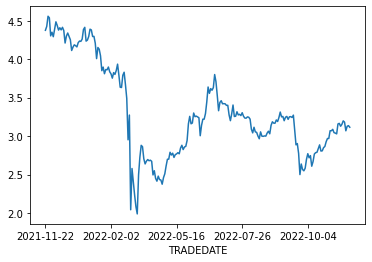

In [ ]:
# indeed everything is correct
df['IRAO'].dropna().plot();

Now, we want to compute the annualized returns and construct the covarianve matrix for further optimisation by normalizing prices for each asset

In [ ]:
#vector of total returns for each asset
initial_prices = []

#get index of first non-na value for column and retrieve the value by index for each column, save into list
for column in constituents_data:
  initial_prices.append(constituents_data[column].loc[constituents_data[column].first_valid_index()])

#create Series out of list with corresponding indices
initial_prices = pd.Series(initial_prices, index = tickers)

In [ ]:
# divide last row by initial values
total_returns = constituents_data.tail(1)/initial_prices

In [ ]:
# take the days of trading for the oldest stock to get the average number of trading days per year
average_trading_days = 365.25 * (len(constituents_data) / 
                                 (pd.to_datetime(constituents_data.index[-1], format='%Y-%m-%d') 
                                - pd.to_datetime(constituents_data.index[0], format='%Y-%m-%d'))
                                 .days)
average_trading_days

230.570796460177

In [ ]:
# take the annualized return for each stock (by element power raise)
annualized_returns = np.power(total_returns, average_trading_days/constituents_data.count()) - 1
annualized_returns

,AFKS,AFLT,ALRS,CBOM,CHMF,DSKY,ENPG,FIVE,FIXP,GAZP,...,SBERP,SNGS,SNGSP,TATN,TATNP,TCSG,TRNFP,VKCO,VTBR,YNDX
TRADEDATE,,,,,,,,,,,,,,,,,,,,,
2022-11-18,-0.447612,-0.604407,-0.461116,0.005702,-0.487646,-0.499185,-0.498826,-0.265626,-0.418081,-0.49692,...,-0.534731,-0.430927,-0.331665,-0.203766,-0.177353,-0.55463,-0.430888,-0.464752,-0.644105,-0.569397


In [ ]:
#compute covariance matrix
daily_returns.cov()

,AFKS,AFLT,ALRS,CBOM,CHMF,DSKY,ENPG,FIVE,FIXP,GAZP,...,SBERP,SNGS,SNGSP,TATN,TATNP,TCSG,TRNFP,VKCO,VTBR,YNDX
AFKS,0.001462,0.001145,0.000947,0.000516,0.001019,0.000890,0.001193,0.001191,0.000939,0.001079,...,0.001218,0.001192,0.000638,0.001058,0.000967,0.001294,0.000933,0.001291,0.001427,0.001261
AFLT,0.001145,0.001634,0.000831,0.000479,0.001045,0.000953,0.001138,0.001203,0.000860,0.001071,...,0.001208,0.001185,0.000554,0.000843,0.000883,0.001278,0.000973,0.000899,0.001447,0.001219
ALRS,0.000947,0.000831,0.001114,0.000468,0.000668,0.000674,0.000889,0.000904,0.000784,0.000893,...,0.000966,0.000889,0.000721,0.000961,0.000869,0.001011,0.000680,0.001418,0.001010,0.001027
CBOM,0.000516,0.000479,0.000468,0.000501,0.000334,0.000318,0.000524,0.000479,0.000414,0.000564,...,0.000637,0.000512,0.000395,0.000537,0.000522,0.000707,0.000296,0.000951,0.000584,0.000635
CHMF,0.001019,0.001045,0.000668,0.000334,0.001453,0.000747,0.000900,0.000920,0.000649,0.000867,...,0.000946,0.000896,0.000350,0.000744,0.000755,0.000922,0.000900,0.000361,0.001247,0.000888
DSKY,0.000890,0.000953,0.000674,0.000318,0.000747,0.001579,0.000939,0.000954,0.000681,0.000862,...,0.000874,0.000919,0.000434,0.000731,0.000713,0.001112,0.000875,0.000740,0.001057,0.000994
ENPG,0.001193,0.001138,0.000889,0.000524,0.000900,0.000939,0.001635,0.001156,0.001031,0.001138,...,0.001133,0.001157,0.000631,0.000903,0.000847,0.001410,0.000917,0.001168,0.001276,0.001225
FIVE,0.001191,0.001203,0.000904,0.000479,0.000920,0.000954,0.001156,0.001835,0.001068,0.000976,...,0.001134,0.001104,0.000674,0.000909,0.000844,0.001453,0.000780,0.001605,0.001285,0.001409
FIXP,0.000939,0.000860,0.000784,0.000414,0.000649,0.000681,0.001031,0.001068,0.001685,0.000778,...,0.001047,0.001000,0.000715,0.000836,0.000816,0.001248,0.000558,0.001798,0.001111,0.001176
GAZP,0.001079,0.001071,0.000893,0.000564,0.000867,0.000862,0.001138,0.000976,0.000778,0.002260,...,0.001194,0.001088,0.000533,0.001065,0.001048,0.001140,0.000961,0.001043,0.001386,0.001188


As we have computed the covariance matrix we now may solve the optimisation problem to find the long-only minimum variance portfolio

The constraint is that all weights sum up to 1. We also specify that the weights are bound between 0 and 1.

In [ ]:
# function for computing standard deviation of portfolio returns - objective function seeked to minimize
def portfolio_sd(weights):
    return np.sqrt(np.transpose(weights) @ (daily_returns.cov()) @ weights)

# repeat the list with the value (1 / 40) 40 times, and convert list to array
equal_weights = np.array(
  [1 / len(tickers)] * len(tickers)
)

# create 40 tuples of (0, 1), all of which exist within a container tuple
# essentially creating a sequence of (min, max) pairs
bounds = (((0,1), ) * len(tickers))

# Use an anonymous lambda function
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Minimize standard deviation
min_sd_results = sco.minimize(
  # Objective function
  fun = portfolio_sd, 
  # Initial guess, which is the equal weight array
  x0 = equal_weights, 
  #Sequential Least Squares Programming (SLSQP) method for the minimization
  method = 'SLSQP',
  bounds = bounds, 
  constraints = constraints
)

In [ ]:
# function for computing portfolio return
def portfolio_returns(weights):
    return (np.sum(daily_returns.mean() * weights))

# create metrics df to compare protfolios
metrics = pd.DataFrame(columns = [
    'Name',
    'Expected Daily Return',
    'Standard Deviation',
    'Sharpe Ratio'
])

# create auxillary list for metrics
metrics_aux = ['Min-Var Portfolio']

# expected daily return
min_sd_port_return = portfolio_returns(min_sd_results['x'])
metrics_aux.append(min_sd_port_return.round(10))


In [ ]:
# standard deviation of a portfolio
min_sd_port_sd = portfolio_sd(min_sd_results['x'])
metrics_aux.append(min_sd_port_sd.round(10))

In [ ]:
# sharpe ratio
min_sd_port_sharpe = min_sd_port_return / min_sd_port_sd
metrics_aux.append(min_sd_port_sharpe.round(10))

In [ ]:
# weights for the optimal portfolio
min_sd_weights = pd.Series(min_sd_results['x'], index=tickers)

# append metrics row
metrics.loc[len(metrics)] = metrics_aux

As we have found the minimum-variance portfolio, then compute the metrics for IMOEX index

In [ ]:
# retrieve information about IMOEX
IMOEX_data = pd.DataFrame(apimoex.get_board_history(session, 'IMOEX', board='SNDX', market='index', engine='stock'))
IMOEX_data.set_index(IMOEX_data['TRADEDATE'], inplace=True)
IMOEX_data = IMOEX_data[['CLOSE']]

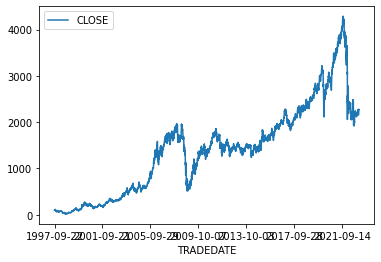

In [ ]:
# check data visually
IMOEX_data.plot();

In [ ]:
# truncate data such that it is comparable in dates to asset_data
# use inconvenient structure with iloc as loc is inclusive
IMOEX_data.drop(IMOEX_data.iloc[:IMOEX_data.index.get_loc(constituents_data.index[0])].index, inplace=True)

# normalize index value for the first date
IMOEX_data = IMOEX_data / IMOEX_data.iloc[0] * 100

In [ ]:
# add metrics
IMOEX_daily_return = np.power(IMOEX_data.iloc[-1]/100, 1/len(IMOEX_data)).iloc[0] - 1
IMOEX_std = IMOEX_data.pct_change().dropna().std(ddof=0).iloc[0] #std normalized by N=len(IMOEX_data)
IMOEX_sharpe = IMOEX_daily_return / IMOEX_std

metrics.loc[len(metrics)] = ['IMOEX', IMOEX_daily_return, IMOEX_std, IMOEX_sharpe]

Construct the min-variance portfolio and compare graphically and metrically with IMOEX

In [ ]:
np.power(IMOEX_data.iloc[-1]/100, 1/len(IMOEX_data)) - 1

CLOSE   -0.002268
Name: 2022-11-18, dtype: float64

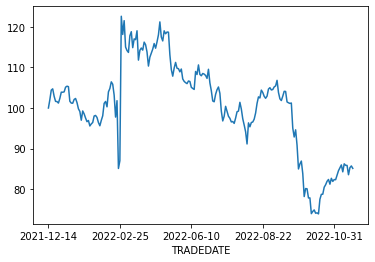

In [ ]:
# multiply matrix by weight vector to get price of a protfolio
min_var_portfolio = constituents_data @ min_sd_weights

# normalize price of the portfolio to 100
min_var_portfolio = min_var_portfolio/min_var_portfolio[0] * 100

# check data visually
min_var_portfolio.plot();

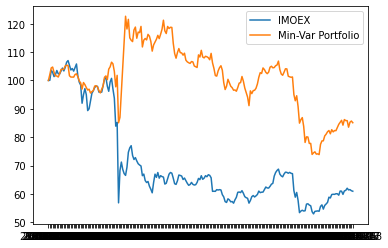

In [ ]:
# compare graphs on the same figure
IMOEX_data.rename(columns={'CLOSE': 'IMOEX'})
min_var_portfolio.name = 'Min-Var Portfolio'
plt.plot(IMOEX_data.index, IMOEX_data)
plt.plot(min_var_portfolio.index, min_var_portfolio)
plt.legend(['IMOEX', 'Min-Var Portfolio'])
plt.show();

In [ ]:
# compare metrics
metrics

,Name,Expected Daily Return,Standard Deviation,Sharpe Ratio
0,Min-Var Portfolio,-0.000036,0.020260,-0.001758
1,IMOEX,-0.002268,0.035089,-0.064634


In [ ]:
# useful functions to work with moex api

'''
with requests.Session() as session:
  apimoex.find_security_description(session, 'IMOEX')
  apimoex.get_reference(session, placeholder='engines')
  apimoex.get_reference(session, placeholder='boards')
  apimoex.get_reference(session, placeholder='markets')
'''

"\nwith requests.Session() as session:\n  apimoex.find_security_description(session, 'IMOEX')\n  apimoex.get_reference(session, placeholder='engines')\n  apimoex.get_reference(session, placeholder='boards')\n  apimoex.get_reference(session, placeholder='markets')\n"

In [ ]:
#to-do

# за какой период оптимально брать данные для построения портфолио
# учитывать arbitrary risk-free-rate, а не 0 как сейчас
# не слежу за ребалансировкой IMOEX
# у IMOEX данные не за все доступные по акции периоды по сравнению с другими мониторингами котировок
# не разобрался как закрыть session и нужно ли
# я не до конца понимаю нужно с n считать или с n-1 st dev у IMOEX_data
# построить автоматическую ребалансировку